In [8]:
import sys
if not '/home/pop518504/git/asax-fabian' in sys.path:
    sys.path.insert(0, '/home/pop518504/git/gknet-benchmarks')
    
from misc.jax_nve_nl import NveSimulation
from matplotlib import pyplot as plt

In [9]:
def plot_runtimes(md, skip_outliers=False):
    plt.title("{}\ndt={}, n={}".format("Lennard-Jones (NL) Argon NVE runtime", md.dt, len(md.atoms)))
    plt.xlabel("Steps")
    plt.ylabel("Runtime [ms]")
    
    step_times = md.step_times_ms
    indices = list(range(len(step_times)))
    
    if skip_outliers:
        # skip initial NL calculation
        indices = indices[1:]
        step_times = step_times[1:]

        # skip NL recalculations
        nl_event_indices = list(map(lambda ne_idx: ne_idx - 1, md.nl_recalculation_events))  # we omit the first value: shift index by 1
                
        # if we want to remove these outliers (breaks up plot)
        # indices = list(map(lambda i: i if i not in nl_event_indices else None, indices))
        # step_times = list(map(lambda st: st if step_times.index(st) not in nl_event_indices else None, step_times))  
        
        # smooth with previous runtime instead (no breaking up)
        step_times = list(map(lambda st: st if step_times.index(st) not in nl_event_indices else step_times[step_times.index(st) - 1], step_times))  
        
        # scatter NL recalculation events w/ smoothed runtime
        nl_events = list(map(lambda i: step_times[i], nl_event_indices))
        plt.scatter(nl_event_indices, nl_events, color = 'red')

    plt.plot(indices, step_times)

# Plain JAX-MD

In [4]:
from ase import units
md = NveSimulation(atoms, dt=5 * units.fs)
md.run(steps=2000)

NL overflow, recomputing...
NL overflow, recomputing...


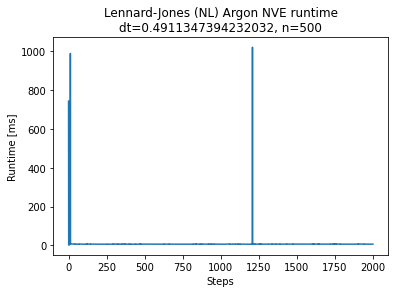

In [5]:
plot_runtimes(md)

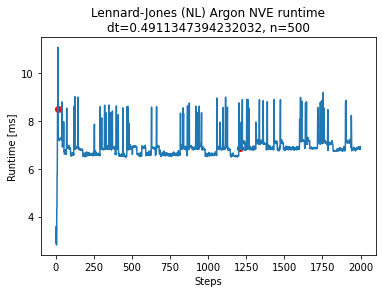

In [6]:
plot_runtimes(md, skip_outliers=True)

In [10]:
sum(md.step_times_ms) / 1000

16.544149999999927

# Plain ASE

In [1]:
# 100 steps: 160.7 ms/step
# 500 steps: 73.4 ms/step
# 1000 steps: 62.19 ms/step
# 2000 steps: 62.81 ms/step

# asax
- Energy calculation using JAX-MD but ASE MD runner
- The more steps performed, the lower ms/step
- TODO: Probably some async JAX issue

In [ ]:
from statistics import mean
from ase.build import bulk
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from jax import jit, lax, random
from jax_md import energy, space, simulate, quantity
import time
import asax
from asax.jax_utils import *
from jax.config import config
config.update("jax_enable_x64", True)


def initialize_system():
    atoms = bulk("Ar", cubic=True) * [5, 5, 5]
    MaxwellBoltzmannDistribution(atoms, temperature_K=300)
    Stationary(atoms)

    # TODO: Remove later
    atoms.calc = asax.lj.LennardJones(epsilon=1.5, sigma=2.0, rc=10.0, ro=6.0)

    box = atoms.get_cell().array
    R = atoms.get_positions()
    return atoms, box, R


def get_potential(displacement_fn, box):
    sigma = 2.0
    epsilon = 1.5
    rc = 10.0
    ro = 6.0
    normalized_ro = ro / sigma
    normalized_rc = rc / sigma
    return energy.lennard_jones_neighbor_list(displacement_fn, box,
                                              sigma=sigma,
                                              epsilon=epsilon,
                                              r_onset=normalized_ro,
                                              r_cutoff=normalized_rc)


def get_step_fn(apply_fn, neighbor_fn):
    def step_fn(i, state):
        state, neighbors = state
        neighbors = neighbor_fn(state.position, neighbors)
        state = apply_fn(state, neighbor=neighbors)
        return state, neighbors

    return step_fn


def run_nve(steps: int, step_fn, neighbor_fn, state, neighbors):
    i = 0

    step_times = []
    # potential_energy = []
    # kinetic_energy = []

    # print_every = 1
    old_time = time.monotonic()
    print('Step\tKE\tPE\tTotal Energy\ttime/step')
    print('----------------------------------------')

    while i < steps:
        # TODO: why 0 to 100?
        state, neighbors = lax.fori_loop(0, 100, step_fn, (state, neighbors))

        if neighbors.did_buffer_overflow:
            print("NL overflow, recomputing...")
            neighbors = neighbor_fn(state.position)
            continue

        # potential_energy += [energy_fn(state.position, neighbor=neighbors)]
        # kinetic_energy += [quantity.kinetic_energy(state.velocity)]

        now = time.monotonic()
        step_ms = round((now - old_time) * 1000, 2)
        step_times.append(step_ms)
        old_time = now
        # print("step {} took {} ms".format(i, step_ms))

        # if i % print_every == 0 and i > 0:
            # new_time = time.time()
            # print('{}\t{:.2f}\t{:.2f}\t{:.3f}\t{:.2f}'.format(
            #     i * print_every, kinetic_energy[-1], potential_energy[-1], kinetic_energy[-1] + potential_energy[-1],
            #     (new_time - old_time) / print_every / 10.0))
            # old_time = new_time

        i += 1

    return step_times


def setup_nve(box, R):
    displacement_fn, shift_fn = space.periodic_general(box, fractional_coordinates=False)
    displacement_fn = jit(displacement_fn)
    neighbor_fn, energy_fn = get_potential(displacement_fn, box)
    initial_neighbor_list = neighbor_fn(R)

    energy_fn = jit(energy_fn)
    shift_fn = jit(shift_fn)

    _, apply_fn = simulate.nve(energy_fn, shift_fn, dt=dt)
    initial_state = get_initial_nve_state(atoms)
    step_fn = get_step_fn(apply_fn, neighbor_fn)

    return initial_state, step_fn, initial_neighbor_list, neighbor_fn